# 3.2 – Logistic Regression no MNIST (PyTorch)

**Melhorias implementadas:**
1) **Loop de treinamento completo** com `DataLoader`, registro de *loss* e *accuracy* por época, e gráficos.
2) **Avaliação robusta** no conjunto de teste: acurácia, **matriz de confusão**, **classification report** e visualização de amostras (acertos/erros).

Este notebook é auto-contido: baixa o MNIST via `torchvision` e treina um modelo de **regressão logística** (`nn.Linear(784, 10)`) para classificação dos dígitos (0–9).

## 1. Imports, semente e dispositivo

In [1]:
%matplotlib inline
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import itertools

# Reprodutibilidade
torch.manual_seed(1234)
np.random.seed(1234)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

## 2. Dados – MNIST com DataLoader

In [2]:
# Transformação: ToTensor + normalização padrão do MNIST
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

train_ds = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_ds  = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

batch_size = 128
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)
test_loader  = DataLoader(test_ds, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)

len(train_ds), len(test_ds)

100%|██████████| 9.91M/9.91M [00:06<00:00, 1.55MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 178kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 2.18MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 2.85MB/s]


(60000, 10000)

## 3. Modelo – Regressão Logística (Linear 784→10)

In [3]:
class LogisticRegressionMNIST(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear = nn.Linear(28*28, 10, bias=True)  # com bias por padrão

    def forward(self, x):
        # x: (B,1,28,28) → flatten em (B, 784)
        x = x.view(x.size(0), -1)
        logits = self.linear(x)
        return logits  # CrossEntropyLoss espera logits

model = LogisticRegressionMNIST().to(device)
model

LogisticRegressionMNIST(
  (linear): Linear(in_features=784, out_features=10, bias=True)
)

## 4. Função de perda e otimizador

In [4]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.1)
num_epochs = 10


## 5. Treinamento – loop por épocas com métricas

In [5]:
def accuracy_from_logits(logits, targets):
    preds = logits.argmax(dim=1)
    return (preds == targets).float().mean()

history = {
    'loss_train': [], 'acc_train': [],
    'loss_test':  [], 'acc_test':  []
}

# Listas para armazenar os gradientes da classe 4 (peso da linha 4 de nn.Linear)
grad_class4_per_epoch = []     # versão "flatten" (784,) por época
grad4_stats_per_epoch = []     # estatísticas resumidas por época

for epoch in range(1, num_epochs+1):
    # ---- Treino ----
    model.train()
    running_loss, running_acc, n_batches = 0.0, 0.0, 0
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        logits = model(xb)
        loss = criterion(logits, yb)

        optimizer.zero_grad()
        loss.backward()

        # >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
        # (2) Visualização / captura dos gradientes da classe '4'
        # A camada linear tem pesos de shape (10, 784). A linha 4 corresponde ao dígito/classe 4.
        with torch.no_grad():
            if hasattr(model, 'linear') and model.linear.weight.grad is not None:
                g4 = model.linear.weight.grad[4].detach().flatten().cpu()  # (784,)
                # Guardar uma cópia do gradiente desta iteração (média por batch não é trivial; capturamos o último batch da época)
                grad_last_batch = g4.clone()
            else:
                grad_last_batch = torch.zeros(28*28)

        optimizer.step()

        running_loss += loss.item()
        running_acc  += accuracy_from_logits(logits, yb).item()
        n_batches    += 1

    loss_train = running_loss / n_batches
    acc_train  = running_acc  / n_batches

    # ---- Validação/Teste ----
    model.eval()
    test_loss, test_acc, n_batches_t = 0.0, 0.0, 0
    with torch.no_grad():
        for xb, yb in test_loader:
            xb, yb = xb.to(device), yb.to(device)
            logits = model(xb)
            loss   = criterion(logits, yb)
            test_loss += loss.item()
            test_acc  += accuracy_from_logits(logits, yb).item()
            n_batches_t += 1

    loss_test = test_loss / n_batches_t
    acc_test  = test_acc  / n_batches_t

    history['loss_train'].append(loss_train)
    history['acc_train'].append(acc_train)
    history['loss_test'].append(loss_test)
    history['acc_test'].append(acc_test)

    # (1) Impressão ao final de cada época: número da época, perda e acurácia
    print(f"Época {epoch:02d}/{num_epochs} | loss_train={loss_train:.4f} acc_train={acc_train:.4f} | "
          f"loss_test={loss_test:.4f} acc_test={acc_test:.4f}")

    # (2) Registrar e imprimir estatísticas dos gradientes da classe 4 (último batch da época)
    grad_class4_per_epoch.append(grad_last_batch.numpy())

    g = grad_last_batch
    stats = {
        "epoch": epoch,
        "mean": float(g.mean()),
        "std":  float(g.std()),
        "min":  float(g.min()),
        "max":  float(g.max()),
        "l2":   float(torch.linalg.vector_norm(g).item())
    }
    grad4_stats_per_epoch.append(stats)
    print(f"Gradiente (classe 4) — mean={stats['mean']:.3e}, std={stats['std']:.3e}, "
          f"min={stats['min']:.3e}, max={stats['max']:.3e}, l2={stats['l2']:.3e}")

c:\Users\andre\AppData\Local\Programs\Python\Python313\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Época 01/10 | loss_train=0.3701 acc_train=0.8907 | loss_test=0.2947 acc_test=0.9152
Gradiente (classe 4) — mean=-1.666e-03, std=8.412e-03, min=-2.902e-02, max=3.502e-02, l2=2.400e-01
Época 02/10 | loss_train=0.3020 acc_train=0.9135 | loss_test=0.2898 acc_test=0.9205
Gradiente (classe 4) — mean=6.805e-04, std=5.195e-03, min=-1.226e-02, max=1.935e-02, l2=1.466e-01
Época 03/10 | loss_train=0.2906 acc_train=0.9175 | loss_test=0.2867 acc_test=0.9178
Gradiente (classe 4) — mean=-1.303e-03, std=1.292e-02, min=-4.849e-02, max=1.485e-02, l2=3.634e-01
Época 04/10 | loss_train=0.2843 acc_train=0.9201 | loss_test=0.2933 acc_test=0.9156
Gradiente (classe 4) — mean=1.540e-03, std=9.834e-03, min=-4.456e-02, max=1.285e-02, l2=2.785e-01
Época 05/10 | loss_train=0.2783 acc_train=0.9220 | loss_test=0.3001 acc_test=0.9150
Gradiente (classe 4) — mean=8.050e-05, std=4.168e-03, min=-1.530e-02, max=5.528e-03, l2=1.166e-01
Época 06/10 | loss_train=0.2751 acc_train=0.9231 | loss_test=0.2767 acc_test=0.9213
Grad

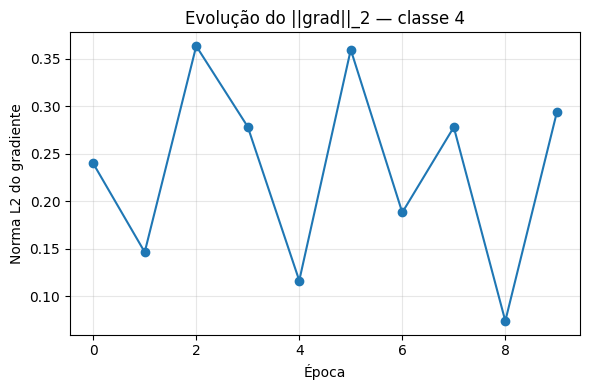

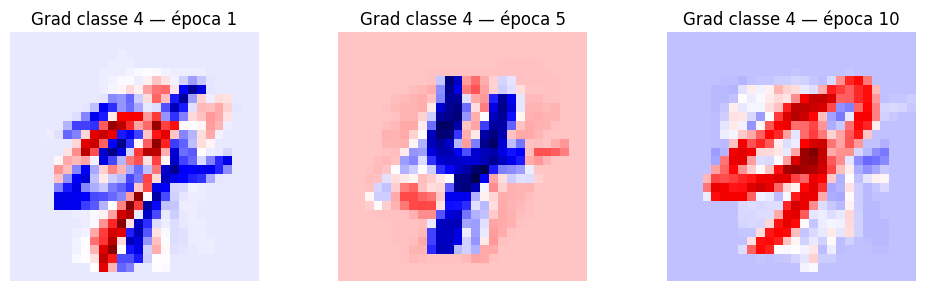

In [6]:

# Visualização dos gradientes da classe 4 (pós-treinamento)

import numpy as np
import matplotlib.pyplot as plt

# Converter para array (num_epochs, 784)
G = np.stack(grad_class4_per_epoch, axis=0)  # shape: (num_epochs, 784)

# 1) Evolução do L2 por época
l2s = [d['l2'] for d in grad4_stats_per_epoch]
plt.figure(figsize=(6,4))
plt.plot(l2s, marker='o')
plt.title('Evolução do ||grad||_2 — classe 4')
plt.xlabel('Época')
plt.ylabel('Norma L2 do gradiente')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# 2) Mostrar alguns mapas 28x28 de gradientes (épocas selecionadas)
epochs_to_show = [1, max(1, num_epochs//2), num_epochs]
plt.figure(figsize=(10,3))
for i, ep in enumerate(epochs_to_show, start=1):
    gimg = G[ep-1].reshape(28,28)
    plt.subplot(1, len(epochs_to_show), i)
    plt.imshow(gimg, cmap='seismic', vmin=-np.max(np.abs(gimg)), vmax=np.max(np.abs(gimg)))
    plt.title(f'Grad classe 4 — época {ep}')
    plt.axis('off')
plt.tight_layout()
plt.show()


### 5.1 Curvas de perda e acurácia

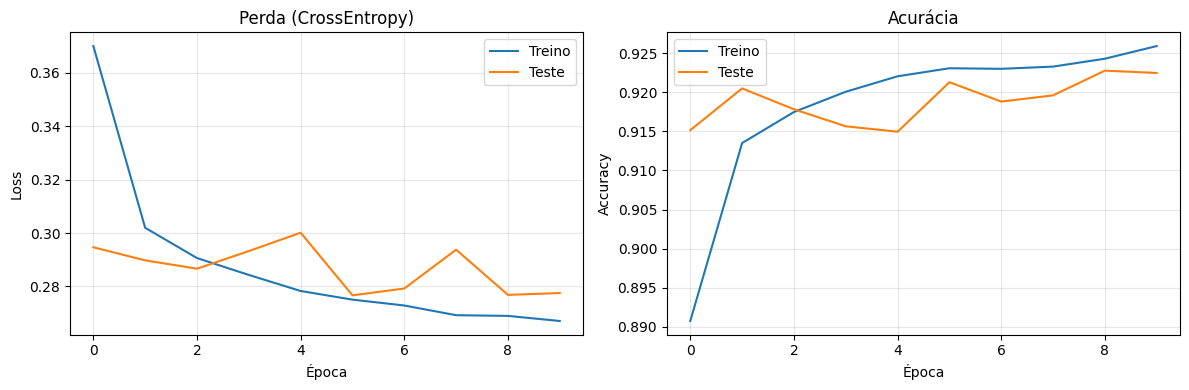

In [7]:
fig, axs = plt.subplots(1, 2, figsize=(12,4))

axs[0].plot(history['loss_train'], label='Treino')
axs[0].plot(history['loss_test'],  label='Teste')
axs[0].set_title('Perda (CrossEntropy)')
axs[0].set_xlabel('Época')
axs[0].set_ylabel('Loss')
axs[0].grid(True, alpha=0.3)
axs[0].legend()

axs[1].plot(history['acc_train'], label='Treino')
axs[1].plot(history['acc_test'],  label='Teste')
axs[1].set_title('Acurácia')
axs[1].set_xlabel('Época')
axs[1].set_ylabel('Accuracy')
axs[1].grid(True, alpha=0.3)
axs[1].legend()

plt.tight_layout()
plt.show()

## 6. Avaliação no conjunto de teste

In [8]:
model.eval()
all_targets, all_preds = [], []
with torch.no_grad():
    for xb, yb in test_loader:
        xb = xb.to(device)
        logits = model(xb)
        preds = logits.argmax(dim=1).cpu().numpy()
        all_preds.append(preds)
        all_targets.append(yb.numpy())

all_preds   = np.concatenate(all_preds)
all_targets = np.concatenate(all_targets)

acc = (all_preds == all_targets).mean()
print(f"Acurácia final no teste: {acc:.4f}")

cm = confusion_matrix(all_targets, all_preds)
print("\nMatriz de Confusão (valores absolutos):\n", cm)

print("\nClassification Report:\n")
print(classification_report(all_targets, all_preds, digits=4))

Acurácia final no teste: 0.9223

Matriz de Confusão (valores absolutos):
 [[ 957    0    2    3    0   10    3    4    1    0]
 [   0 1118    4    1    0    2    3    2    5    0]
 [   4    9  957    4    8    8   11    9   17    5]
 [   4    1   29  872    1   56    2   13   23    9]
 [   1    3    8    1  911    0    7    7    5   39]
 [   9    2    6   17   10  799    9    8   26    6]
 [  10    3   10    1   11   24  896    2    1    0]
 [   1    8   21    4    6    1    0  959    0   28]
 [   6   13    9   13    9   43   10   14  846   11]
 [   9    8    2    6   26   10    0   31    9  908]]

Classification Report:

              precision    recall  f1-score   support

           0     0.9560    0.9765    0.9662       980
           1     0.9597    0.9850    0.9722      1135
           2     0.9132    0.9273    0.9202      1032
           3     0.9458    0.8634    0.9027      1010
           4     0.9277    0.9277    0.9277       982
           5     0.8384    0.8957    0.8661  

### 6.1 Visualização da matriz de confusão

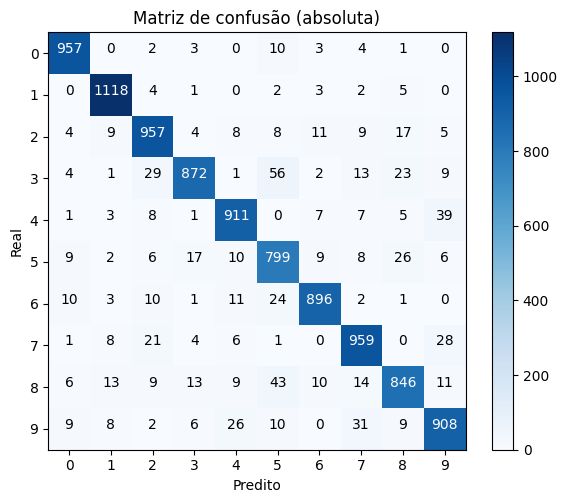

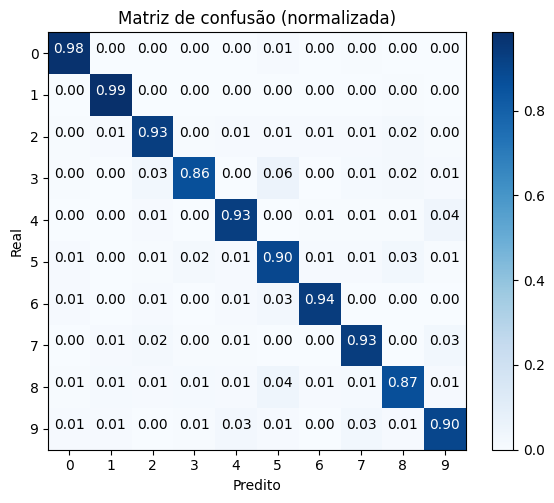

In [9]:
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix'):
    if normalize:
        cm = cm.astype('float') / (cm.sum(axis=1, keepdims=True) + 1e-12)
    plt.figure(figsize=(6,5))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment='center',
                 color='white' if cm[i, j] > thresh else 'black')
    plt.ylabel('Real')
    plt.xlabel('Predito')
    plt.tight_layout()

plot_confusion_matrix(cm, classes=list(range(10)), normalize=False, title='Matriz de confusão (absoluta)')
plot_confusion_matrix(cm, classes=list(range(10)), normalize=True,  title='Matriz de confusão (normalizada)')

## 7. Exemplos de acertos e erros

c:\Users\andre\AppData\Local\Programs\Python\Python313\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


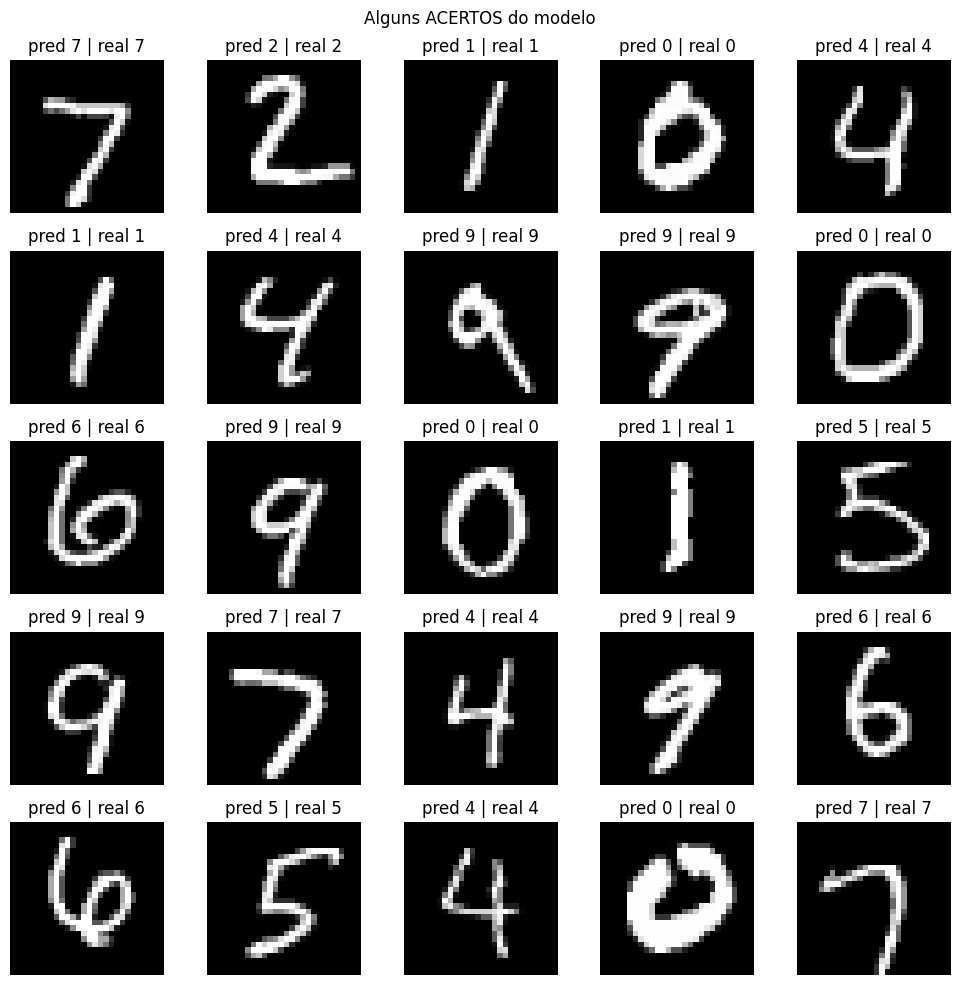

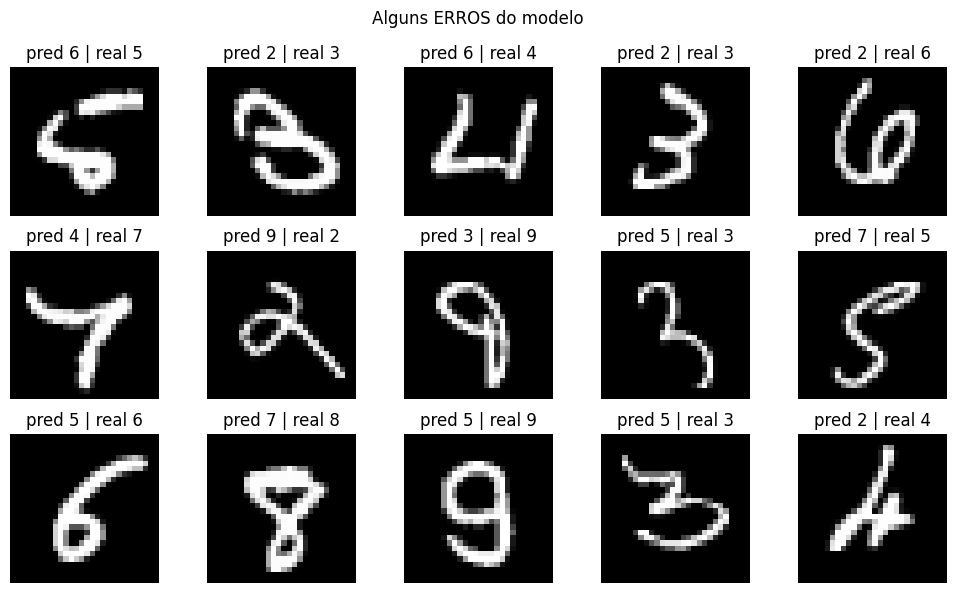

In [10]:
# Reconstruir algumas imagens do test_loader com suas previsões/rotulos
images, labels, preds = [], [], []
model.eval()
with torch.no_grad():
    for xb, yb in test_loader:
        logits = model(xb.to(device))
        yhat = logits.argmax(dim=1).cpu()
        images.append(xb)
        labels.append(yb)
        preds.append(yhat)
        if len(images) * xb.size(0) >= 256:  # coleta ~256 imagens
            break

images = torch.cat(images, dim=0)
labels = torch.cat(labels, dim=0)
preds  = torch.cat(preds,  dim=0)

def show_grid(mask, title):
    idxs = torch.where(mask)[0][:25]
    n = idxs.numel()
    cols = 5
    rows = int(np.ceil(n/cols)) if n>0 else 1
    plt.figure(figsize=(10, 2*rows))
    for i, idx in enumerate(idxs):
        plt.subplot(rows, cols, i+1)
        plt.imshow(images[idx][0].numpy(), cmap='gray')
        plt.title(f"pred {preds[idx].item()} | real {labels[idx].item()}")
        plt.axis('off')
    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

correct_mask = preds.eq(labels)
wrong_mask   = ~correct_mask

show_grid(correct_mask, 'Alguns ACERTOS do modelo')
show_grid(wrong_mask,   'Alguns ERROS do modelo')

## 8. Considerações finais
- Implementamos um fluxo **completo** para regressão logística no MNIST.
- Duas melhorias principais em relação a versões básicas: **loop de treino estruturado** com métricas e **avaliação robusta** (matriz de confusão + report + exemplos).
- Próximos passos naturais: testar **otimizadores** (Adam/RMSProp), **regularização L2** (weight decay), *learning rate schedules*, e aumento do número de épocas.
